# 📋 Notion Inbox Agent: Evaluation Suite

**Navigation:**
- [1. Setup & Config](#setup)
- [2. Debug Data Extraction](#extraction)
- [3. Notion Retrieval](#retrieval)
- [4. Data Alignment](#alignment)
- [5. Analysis & Metrics](#analysis)

---

This notebook retrieves tasks from Notion that match debug tasks in an eval folder, and performs systematic evaluation comparing expected (debug) vs actual (Notion) task properties.

In [1]:
# Imports
import json
import re
from pathlib import Path
from typing import Optional
from notion_client import Client

from inbox_agent.config import settings
from inbox_agent.notion import query_pages_filtered, get_block_plain_text, extract_property_value
from inbox_agent.pydantic_models import NotionTask, AIUseStatus

print("✓ Imports loaded")

✓ Imports loaded


<a id="setup"></a>
## [1] Setup & Configuration

<a id="extraction"></a>
## [2] Debug Data Extraction

Extract Task Model JSON from debug markdown files in the eval folder.

In [2]:
# ============ CONFIGURATION ============
# Control which eval folder to use
EVAL_FOLDER_NAME = "eval_1"  # Change this to use different eval folders (e.g., "eval_2", "eval_3")

# File names for processed tasks
NOTION_TASKS_FILE_NAME = "notion_tasks.json"
DEBUG_TASKS_FILE_NAME = "debug_tasks.json"

# Derived paths
EVAL_FOLDER_PATH = settings.LOGS_DIR / EVAL_FOLDER_NAME
NOTION_TASKS_FILE = EVAL_FOLDER_PATH / NOTION_TASKS_FILE_NAME
DEBUG_TASKS_FILE = EVAL_FOLDER_PATH / DEBUG_TASKS_FILE_NAME

print(f"✓ Eval folder: {EVAL_FOLDER_PATH}")
print(f"✓ Notion tasks will be saved to: {NOTION_TASKS_FILE}")
print(f"✓ Debug tasks will be saved to: {DEBUG_TASKS_FILE}")

✓ Eval folder: D:\Coding\VSCFiles\IndependentProjects\AI\NotionInboxAgent\logs\eval_1
✓ Notion tasks will be saved to: D:\Coding\VSCFiles\IndependentProjects\AI\NotionInboxAgent\logs\eval_1\notion_tasks.json
✓ Debug tasks will be saved to: D:\Coding\VSCFiles\IndependentProjects\AI\NotionInboxAgent\logs\eval_1\debug_tasks.json


In [13]:
# ============ FETCH PROJECT MAPPING ============

def fetch_all_projects(notion_client: Client) -> dict:
    """
    Fetch all projects from Notion database.
    Returns dict mapping project ID -> project title.
    """
    response = query_pages_filtered(
        notion_client,
        settings.NOTION_PROJECTS_DATA_SOURCE_ID,
        filter_properties=["Name"]
    )
    
    id_to_title = {}
    for page in response['results']:
        project_id = page['id']
        project_title = get_block_plain_text(page)
        if project_title:
            id_to_title[project_id] = project_title
    
    return id_to_title

# Initialize Notion client and fetch all projects
notion = Client(auth=settings.NOTION_TOKEN)
project_id_to_title = fetch_all_projects(notion)
print(f"✓ Fetched project mapping: {len(project_id_to_title)} projects")


✓ Fetched project mapping: 334 projects


In [14]:
# ============ STEP 1: Extract Debug Task Information ============

def get_debug_task_files(eval_folder: Path) -> list[Path]:
    """Get all .md debug task files from eval folder."""
    return [f for f in eval_folder.glob("*.md") if f.is_file()]

def extract_task_model_from_debug_file(file_path: Path) -> dict:
    """
    Extract the Task Model JSON from a debug task markdown file.
    
    Returns:
        Dict with task model data, or None if not found
    """
    content = file_path.read_text(encoding='utf-8')
    
    # Find Task Model section
    match = re.search(r'## Task Model\s+```json\s+(.*?)\s+```', content, re.DOTALL)
    if not match:
        return None
    
    try:
        task_data = json.loads(match.group(1))
        return task_data
    except json.JSONDecodeError as e:
        print(f"Warning: Could not parse Task Model JSON in {file_path.name}: {e}")
        return None

def get_debug_task_titles(eval_folder: Path) -> list[str]:
    """Extract all task titles from debug task files in eval folder."""
    debug_files = get_debug_task_files(eval_folder)
    titles = []
    
    for file in debug_files:
        task_model = extract_task_model_from_debug_file(file)
        if task_model and 'title' in task_model:
            titles.append(task_model['title'])
    
    return titles

def load_and_save_debug_tasks(eval_folder: Path, output_file: Path) -> list[dict]:
    """
    Load debug tasks from markdown files and save to JSON.
    
    Args:
        eval_folder: Folder containing debug task markdown files
        output_file: Path to save the JSON file
    
    Returns:
        List of debug task model dicts
    """
    debug_files = get_debug_task_files(eval_folder)
    debug_tasks = []
    
    for file in debug_files:
        task_model = extract_task_model_from_debug_file(file)
        if task_model:
            debug_tasks.append(task_model)
    
    # Save as JSON
    output_file.parent.mkdir(parents=True, exist_ok=True)
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(debug_tasks, f, indent=2, ensure_ascii=False)
    
    return debug_tasks

# Test: Get debug task titles
debug_titles = get_debug_task_titles(EVAL_FOLDER_PATH)
print(f"✓ Found {len(debug_titles)} debug tasks")
print(f"Sample titles: {debug_titles[:3]}")

# Load and save debug tasks to JSON
debug_tasks_loaded = load_and_save_debug_tasks(EVAL_FOLDER_PATH, DEBUG_TASKS_FILE)
print(f"✓ Loaded and saved {len(debug_tasks_loaded)} debug tasks to {DEBUG_TASKS_FILE}")

✓ Found 20 debug tasks
Sample titles: ['Address Trace Building vs. Optimization Disagreement', 'AI Resilience - Potential Complacency', 'Assess Book Creation Process & Claims']
✓ Loaded and saved 20 debug tasks to D:\Coding\VSCFiles\IndependentProjects\AI\NotionInboxAgent\logs\eval_1\debug_tasks.json


<a id="retrieval"></a>
## [3] Notion Retrieval

Fetch matching tasks from Notion production database using optimized OR filters.

In [15]:
# ============ STEP 2: Retrieve Tasks from Notion ============

def retrieve_tasks_from_notion(notion_client: Client, task_titles: list[str]) -> list[dict]:
    """
    Retrieve tasks from Notion based on titles using OR filter.
    
    Args:
        notion_client: Notion client instance
        task_titles: List of task titles to retrieve
    
    Returns:
        List of Notion page objects
    """
    if not task_titles:
        return []
    
    # Build OR filter for all titles
    filter_dict = {
        "or": [
            {"property": "Name", "title": {"equals": title}}
            for title in task_titles
        ]
    }
    
    # Properties to retrieve (relevant to NotionTask model + AIUsefulness, UseAIStatus)
    filter_properties = [
        "Name",           # title
        "Project",        # projects (relation)
        "Importance",     # importance
        "Urgency",        # urgency
        "Impact Score",   # impact
        "UseAIStatus",    # ai_use_status
        "AIUsefulness"    # additional evaluation property
    ]
    
    # Query Notion
    response = query_pages_filtered(
        notion_client,
        settings.NOTION_TASKS_DATA_SOURCE_ID,
        filter_dict=filter_dict,
        filter_properties=filter_properties
    )
    
    return response['results']

# Retrieve tasks
notion_tasks_raw = retrieve_tasks_from_notion(notion, debug_titles)

print(f"✓ Retrieved {len(notion_tasks_raw)} tasks from Notion")
if notion_tasks_raw:
    print(f"Sample task ID: {notion_tasks_raw[0]['id']}")

✓ Retrieved 19 tasks from Notion
Sample task ID: 30acb17d-cc44-8106-b290-c17efc29b045


In [16]:
# ============ STEP 3: Parse and Save Notion Tasks ============

def parse_notion_task(notion_page: dict, id_to_title_map: dict) -> dict:
    """
    Parse a Notion page object into a simplified task dict.
    Converts project IDs to titles for comparison with debug predictions.
    
    Args:
        notion_page: Notion page object
        id_to_title_map: Mapping of project ID -> project title
    
    Returns:
        Dict with task properties extracted from Notion
    """
    props = notion_page.get('properties', {})
    
    # Extract title
    title = get_block_plain_text(notion_page)
    
    # Extract properties using reusable helper
    importance = extract_property_value(props.get('Importance'))
    urgency = extract_property_value(props.get('Urgency'))
    ai_status = extract_property_value(props.get('UseAIStatus'))
    ai_usefulness = extract_property_value(props.get('AIUsefulness'))
    impact = extract_property_value(props.get('Impact Score'))
    
    # Convert string importance/urgency to int if available
    importance = int(importance) if importance else None
    urgency = int(urgency) if urgency else None
    
    # Extract project relations and convert IDs to titles
    project_relations = props.get('Project', {}).get('relation', [])
    project_titles = [id_to_title_map.get(rel['id'], rel['id']) for rel in project_relations]
    
    return {
        'id': notion_page['id'],
        'title': title,
        'importance': importance,
        'urgency': urgency,
        'impact': impact,
        'ai_use_status': ai_status,
        'ai_usefulness': ai_usefulness,
        'projects': project_titles,
        'created_time': notion_page.get('created_time'),
        'last_edited_time': notion_page.get('last_edited_time')
    }

def save_notion_tasks(tasks_raw: list[dict], output_file: Path, id_to_title_map: dict):
    """Parse and save Notion tasks to JSON file."""
    parsed_tasks = [parse_notion_task(task, id_to_title_map) for task in tasks_raw]
    
    # Save as JSON
    output_file.parent.mkdir(parents=True, exist_ok=True)
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(parsed_tasks, f, indent=2, ensure_ascii=False)
    
    return parsed_tasks

# Parse and save
notion_tasks_parsed = save_notion_tasks(notion_tasks_raw, NOTION_TASKS_FILE, project_id_to_title)
print(f"✓ Saved {len(notion_tasks_parsed)} parsed Notion tasks to {NOTION_TASKS_FILE}")
print(f"✓ Sample task: {notion_tasks_parsed[0]['title'] if notion_tasks_parsed else 'None'}")

✓ Saved 19 parsed Notion tasks to D:\Coding\VSCFiles\IndependentProjects\AI\NotionInboxAgent\logs\eval_1\notion_tasks.json
✓ Sample task: Performance Boost - Training & Rest


<a id="alignment"></a>
## [4] Data Alignment

Match debug (expected) tasks with Notion (actual) tasks by title for evaluation.

In [17]:
# ============ STEP 4: Load and Pair Tasks ============

def load_tasks_from_json(json_file: Path) -> list[dict]:
    """
    Generic loader for tasks from JSON file.
    Works for both Notion tasks and debug tasks.
    """
    if not json_file.exists():
        return []
    
    with open(json_file, 'r', encoding='utf-8') as f:
        return json.load(f)

def create_task_pairs(notion_tasks_file: Path, debug_tasks_file: Path) -> list[tuple[dict, dict]]:
    """
    Create pairs of (notion_task, debug_task) for evaluation by matching titles.
    
    Args:
        notion_tasks_file: Path to Notion tasks JSON file
        debug_tasks_file: Path to debug tasks JSON file
    
    Returns:
        List of tuples where each tuple is (notion_task_dict, debug_task_model_dict)
    """
    # Load both datasets from JSON files
    notion_tasks = load_tasks_from_json(notion_tasks_file)
    debug_tasks = load_tasks_from_json(debug_tasks_file)
    
    # Create dict for O(1) lookup by title
    debug_tasks_by_title = {task['title']: task for task in debug_tasks}
    
    # Create pairs based on matching titles
    pairs = []
    matched_titles = set()
    
    for notion_task in notion_tasks:
        title = notion_task['title']
        if title in debug_tasks_by_title:
            pairs.append((notion_task, debug_tasks_by_title[title]))
            matched_titles.add(title)
    
    # Report unmatched tasks
    unmatched_debug = set(debug_tasks_by_title.keys()) - matched_titles
    unmatched_notion = {t['title'] for t in notion_tasks} - matched_titles
    
    print(f"✓ Created {len(pairs)} task pairs")
    if unmatched_debug:
        print(f"⚠ {len(unmatched_debug)} debug tasks not found in Notion")
        print(f"  Sample unmatched: {list(unmatched_debug)[:3]}")
    if unmatched_notion:
        print(f"⚠ {len(unmatched_notion)} Notion tasks not found in debug")
        print(f"  Sample unmatched: {list(unmatched_notion)[:3]}")
    
    return pairs

# Create task pairs
task_pairs = create_task_pairs(NOTION_TASKS_FILE, DEBUG_TASKS_FILE)
print(f"\n{'='*60}")
print(f"EVALUATION DATASET READY")
print(f"{'='*60}")
print(f"Total pairs: {len(task_pairs)}")
if task_pairs:
    print(f"\nSample pair:")
    print(f"  Notion task: {task_pairs[0][0]['title']}")
    print(f"  Debug task:  {task_pairs[0][1]['title']}")

✓ Created 19 task pairs
⚠ 1 debug tasks not found in Notion
  Sample unmatched: ['Clarify Visualization Cost Assumptions']

EVALUATION DATASET READY
Total pairs: 19

Sample pair:
  Notion task: Performance Boost - Training & Rest
  Debug task:  Performance Boost - Training & Rest


<a id="analysis"></a>
## [5] Analysis & Metrics

Compute evaluation metrics comparing debug tasks (expected intent) vs Notion tasks (actual state).

In [18]:
# Imports for analysis
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

print("✓ Analysis libraries loaded")

✓ Analysis libraries loaded


In [19]:
# ============ MINIMAL METRIC FUNCTIONS ============

def _safe_pairs(pairs, prop_name):
    """Extract property pairs where both notion and debug values exist."""
    return [
        (n.get(prop_name), d.get(prop_name))
        for n, d in pairs
        if n.get(prop_name) is not None and d.get(prop_name) is not None
    ]

def calculate_mae(pairs, prop_name):
    """Mean Absolute Error for numeric properties (converts string to float)."""
    diffs = []
    for n, d in pairs:
        n_val, d_val = n.get(prop_name), d.get(prop_name)
        if n_val is None or d_val is None:
            continue
        try:
            diffs.append(abs(float(n_val) - float(d_val)))
        except (TypeError, ValueError):
            continue
    return float(np.mean(diffs)) if diffs else 0.0

def calculate_accuracy(pairs, prop_name):
    """Exact match accuracy for categorical properties."""
    vals = _safe_pairs(pairs, prop_name)
    if not vals:
        return 0.0
    return sum(1 for n_val, d_val in vals if n_val == d_val) / len(vals)

def calculate_top_k_project_accuracy(pairs, k=3):
    """
    Top-k project accuracy: Check if actual project appears in top-k predicted.
    Both now use project titles for consistent comparison.
    """
    correct = 0
    total = 0
    for notion, debug in pairs:
        actual_proj = set(notion.get("projects", []))
        predicted_projs = debug.get("projects", [])[:k] if debug.get("projects") else []
        if actual_proj and predicted_projs:
            if any(p in actual_proj for p in predicted_projs):
                correct += 1
            total += 1
    return correct / total if total > 0 else 0.0

def calculate_f1(pairs, prop_name):
    """
    F1 score for boolean property.
    Handles True/False and truthy/falsy values.
    """
    vals = _safe_pairs(pairs, prop_name)
    if not vals:
        return 0.0
    
    tp = sum(1 for n_val, d_val in vals if n_val and d_val)
    fp = sum(1 for n_val, d_val in vals if not n_val and d_val)
    fn = sum(1 for n_val, d_val in vals if n_val and not d_val)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

def print_metrics_summary(pairs):
    """Print concise metrics table."""
    results = {
        "Importance MAE": calculate_mae(pairs, "importance"),
        "Urgency MAE": calculate_mae(pairs, "urgency"),
        "AI Status Acc": calculate_accuracy(pairs, "ai_use_status"),
        "Impact MAE": calculate_mae(pairs, "impact"),
        "Top-3 Project Acc": calculate_top_k_project_accuracy(pairs, k=3),
        "Do Now F1": calculate_f1(pairs, "do_now"),
    }
    
    print("\n" + "="*60)
    print(f"{'METRIC':<25} {'VALUE':>10}")
    print("-"*60)
    for k, v in results.items():
        if "MAE" in k:
            print(f"{k:<25} {v:>10.3f}")
        else:
            print(f"{k:<25} {v:>9.1%}")
    print("="*60)
    return results

# Compute and display
metrics = print_metrics_summary(task_pairs)
print(f"\n✓ Sample size: {len(task_pairs)} task pairs")


METRIC                         VALUE
------------------------------------------------------------
Importance MAE                 0.421
Urgency MAE                    0.526
AI Status Acc                  5.3%
Impact MAE                     0.263
Top-3 Project Acc             50.0%
Do Now F1                      0.0%

✓ Sample size: 19 task pairs


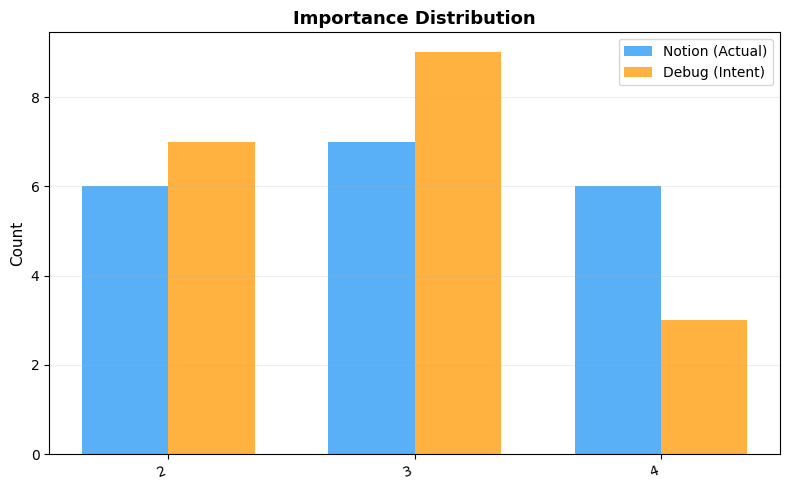

In [20]:
# ============ GENERALIZED DISTRIBUTION PLOT ============

def plot_property_distribution(pairs, prop_name, title=None):
    """
    Reusable distribution comparison for any categorical property.
    
    Args:
        pairs: List of (notion_task, debug_task) tuples
        prop_name: Property name to compare (e.g., 'importance', 'urgency')
        title: Optional custom title
    """
    plt.style.use("seaborn-v0_8-muted")
    
    n_vals = [n.get(prop_name) for n, _ in pairs if n.get(prop_name) is not None]
    d_vals = [d.get(prop_name) for _, d in pairs if d.get(prop_name) is not None]
    
    labels = sorted({*n_vals, *d_vals}, key=lambda x: str(x))
    if not labels:
        print(f"No values found for '{prop_name}'.")
        return
    
    n_count = Counter(n_vals)
    d_count = Counter(d_vals)
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width / 2, [n_count[l] for l in labels], width, 
           label="Notion (Actual)", alpha=0.75, color='#2196F3')
    ax.bar(x + width / 2, [d_count[l] for l in labels], width, 
           label="Debug (Intent)", alpha=0.75, color='#FF9800')
    
    ax.set_title(title or f"{prop_name.replace('_', ' ').title()} Distribution", 
                 fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([str(l) for l in labels], rotation=20, ha="right")
    ax.set_ylabel("Count", fontsize=11)
    ax.legend()
    ax.grid(axis="y", alpha=0.2)
    plt.tight_layout()
    plt.show()

# Example: Plot importance distribution
plot_property_distribution(task_pairs, "importance")

In [21]:
# ============ TASK COMPARISON SLIDE ============

def compare_task_slide(index, pairs=None):
    """
    Visual comparison 'slide' of a specific debug/notion task pair.
    Shows property alignment, match status, AI feedback, and enrichment.
    
    Args:
        index: Index of the task pair to inspect
        pairs: List of task pairs (defaults to task_pairs)
    """
    if pairs is None:
        pairs = task_pairs
    
    if not pairs:
        print("No task pairs available.")
        return
    if index < 0 or index >= len(pairs):
        print(f"Index out of range: {index} (available: 0-{len(pairs)-1})")
        return
    
    n, d = pairs[index]
    title = n.get("title") or d.get("title") or f"Task #{index}"
    
    print(f"\n{'='*90}")
    print(f"TASK COMPARISON SLIDE: {str(title).upper()}")
    print(f"{'='*90}")
    
    props = ["importance", "urgency", "impact", "ai_use_status"]
    print(f"{'PROPERTY':<18} | {'NOTION (Actual)':<24} | {'DEBUG (Intent)':<24} | MATCH")
    print("-" * 90)
    for p in props:
        nv, dv = n.get(p), d.get(p)
        match = "✓" if nv == dv and nv is not None and dv is not None else "✗"
        print(f"{p:<18} | {str(nv):<24} | {str(dv):<24} | {match}")
    
    print("\n" + "-" * 90)
    print("AI FEEDBACK LOOP")
    print(f"  AIUsefulness:  {n.get('ai_usefulness', 'NOT RATED')}")
    print(f"  Confidence:    {float(d.get('confidence') or 0.0):.2f}")
    
    enr = d.get("enrichment") or "N/A"
    print("\n" + "-" * 90)
    print("ENRICHMENT DELTA")
    print(f"  {str(enr)[:280]}{'...' if len(str(enr)) > 280 else ''}")
    print(f"{'='*90}\n")

# Example: Inspect first pair
if task_pairs:
    compare_task_slide(0)


TASK COMPARISON SLIDE: PERFORMANCE BOOST - TRAINING & REST
PROPERTY           | NOTION (Actual)          | DEBUG (Intent)           | MATCH
------------------------------------------------------------------------------------------
importance         | 2                        | 2                        | ✓
urgency            | 1                        | 1                        | ✓
impact             | 20                       | 20                       | ✓
ai_use_status      | processed                | ambiguous                | ✗

------------------------------------------------------------------------------------------
AI FEEDBACK LOOP
  AIUsefulness:  very high
  Confidence:    0.85

------------------------------------------------------------------------------------------
ENRICHMENT DELTA
  **[LENS A]**: Core truth is performance fluctuates due to physiological state. Training *might* influence this, but rest (recovery) is a primary driver of cognitive function and physical endu

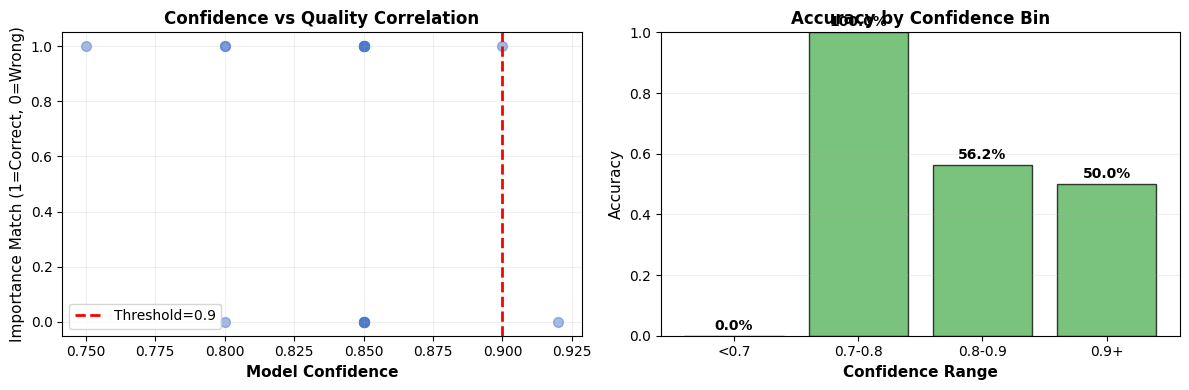


📊 Confidence Analysis:
  Overall importance accuracy: 57.9%
  High confidence (≥0.9) accuracy: 50.0%
  Sample size: 19 pairs



In [22]:
# ============ HIGH-SIGNAL ANALYSIS: Confidence vs Accuracy ============

def plot_confidence_quality(pairs, prop_name="importance"):
    """
    Analyze whether model confidence correlates with prediction quality.
    Critical for validating the project_confidence_threshold=0.9 setting.
    
    Args:
        pairs: List of (notion_task, debug_task) tuples
        prop_name: Property to check matches for
    """
    clean = [
        (float(d.get("confidence", 0)), 1 if n.get(prop_name) == d.get(prop_name) else 0)
        for n, d in pairs
        if d.get("confidence") is not None 
        and n.get(prop_name) is not None 
        and d.get(prop_name) is not None
    ]
    
    if not clean:
        print("No valid points for confidence analysis.")
        return
    
    conf, matches = zip(*clean)
    
    # Calculate accuracy by confidence bins
    bins = [0, 0.7, 0.8, 0.9, 1.0]
    bin_labels = ["<0.7", "0.7-0.8", "0.8-0.9", "0.9+"]
    bin_accs = []
    
    for i in range(len(bins) - 1):
        mask = [(bins[i] <= c < bins[i+1]) or (i == len(bins)-2 and c == bins[i+1]) 
                for c in conf]
        bin_matches = [m for m, included in zip(matches, mask) if included]
        if bin_matches:
            bin_accs.append(sum(bin_matches) / len(bin_matches))
        else:
            bin_accs.append(0)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Scatter plot
    ax1.scatter(conf, matches, alpha=0.5, s=50)
    ax1.set_xlabel("Model Confidence", fontsize=11, fontweight='bold')
    ax1.set_ylabel(f"{prop_name.title()} Match (1=Correct, 0=Wrong)", fontsize=11)
    ax1.set_title("Confidence vs Quality Correlation", fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.2)
    ax1.axvline(x=0.9, color='red', linestyle='--', linewidth=2, label='Threshold=0.9')
    ax1.legend()
    
    # Binned accuracy
    ax2.bar(bin_labels, bin_accs, color='#4CAF50', alpha=0.75, edgecolor='black')
    ax2.set_xlabel("Confidence Range", fontsize=11, fontweight='bold')
    ax2.set_ylabel("Accuracy", fontsize=11)
    ax2.set_title("Accuracy by Confidence Bin", fontsize=12, fontweight='bold')
    ax2.set_ylim(0, 1.0)
    ax2.grid(axis='y', alpha=0.2)
    for i, v in enumerate(bin_accs):
        ax2.text(i, v + 0.02, f"{v:.1%}", ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Confidence Analysis:")
    print(f"  Overall {prop_name} accuracy: {sum(matches)/len(matches):.1%}")
    print(f"  High confidence (≥0.9) accuracy: {bin_accs[-1]:.1%}")
    print(f"  Sample size: {len(clean)} pairs\n")

# Run confidence analysis
plot_confidence_quality(task_pairs, "importance")

## Quick Reference

**Metrics (in `print_metrics_summary`):**
- **Importance MAE** / **Urgency MAE** - Mean Absolute Error for ordinal properties (1-3 scale)
- **Impact MAE** - Numeric error for impact score
- **AI Status Acc** - Exact match accuracy for categorical AI use status
- **Top-3 Project Acc** - Fraction where actual project appears in top-3 predicted
- **Do Now F1** - F1 score for boolean "do now" property

**Utility Functions:**
- `plot_property_distribution(pairs, prop_name)` - Visualize any property distribution
- `compare_task_slide(index)` - Detailed task pair comparison with enrichment
- `plot_confidence_quality(pairs, prop_name)` - Analyze confidence vs accuracy

**Data Structures:**
- `task_pairs` - List of (notion_task, debug_task) tuples
- `notion_tasks_parsed` - All Notion tasks
- `debug_tasks_loaded` - All debug tasks